In this short notebook, I present a minimal example of a low dimensional diffusion model (in jax/optax/haiku) running on CPU.

In [175]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import haiku as hk
from torch.utils.data import Dataset, dataloader

print('JAX version: {}'.format(jax.__version__))

JAX version: 0.3.7


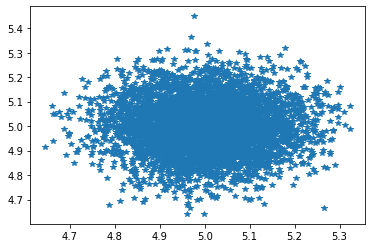

In [176]:
N_samples = 5000
dimension = 2

std = 0.105
# shift = np.random.randint(0, size=(N_samples, dimension)) - 0
shift = 5
X_train = std * np.random.randn(N_samples, dimension) + shift

import matplotlib.pyplot as plt
plt.plot(X_train[:, 0], X_train[:,1], '*')
plt.show()

First, we start by defining a target dataset and the diffusion dataset.

In [177]:
T = 5

class TargetDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.N_samples = X.shape[0]
        self.dimension = X.shape[1]

    def __len__(self):
        return self.N_samples

    def __getitem__(self, idx):
        return self.X[idx, :]

class DiffusionDataset(Dataset):
    def __init__(self, target_ds, T):
        self.target_ds = target_ds
        self.T = T

    def __len__(self):
        return self.target_ds.__len__()

    def sampler(self, t, x0):        
        coeff1 = np.exp(-t)
        coeff2 = np.sqrt(1 - np.exp(-2*t))
        z = np.random.randn(*x0.shape)
        xt = coeff1 * x0 + coeff2 * z
        return np.expand_dims(t, axis=0), xt, z / coeff2

    def __getitem__(self, idx):
        t = np.random.uniform(0, self.T)
        x0 = self.target_ds.__getitem__(idx)
        return self.sampler(t, x0)

target_ds = TargetDataset(X_train)
diff_ds = DiffusionDataset(target_ds, T)

We now define dataloaders (with torch) from these datasets.
The only difficulty is that we have to modify the collate function from torch.

In [178]:
bs = 128

def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        transposed = zip(*batch)
        return [numpy_collate(np.array(samples)) for samples in transposed]

diff_dl = dataloader.DataLoader(diff_ds, batch_size=bs, shuffle=True, collate_fn=numpy_collate)

We now define the loss function which is the classical square loss.

In [179]:
def compute_loss(params, model, t, xt, pred):
    out = model.apply(params, t, xt).squeeze()
    return jnp.mean(optax.l2_loss(out, -pred.squeeze()))

We now define the model.

In [180]:
def ScoreNetwork(t, x):
    mlpt = hk.Sequential([hk.Linear(16), jax.nn.relu,
    hk.Linear(16), jax.nn.relu,])
    mlpx = hk.Sequential([hk.Linear(16), jax.nn.relu,
    hk.Linear(16), jax.nn.relu,])    
    mlpconcat = hk.Sequential([hk.Linear(32), jax.nn.relu,
    hk.Linear(32), jax.nn.relu,
    hk.Linear(x.shape[-1]),]) 
    outt = mlpt(t)
    outx = mlpx(x)
    return mlpconcat(jnp.concatenate((outt, outx), axis=-1))

model = hk.transform(ScoreNetwork)
model = hk.without_apply_rng(model)

We define the optimizer and train the model.

In [181]:
nepoch = 1000
nlog = 100
lr = 1e-3

optimizer = optax.adam(lr)
outinit = next(iter(diff_dl))
key = jax.random.PRNGKey(42)
params = model.init(key, outinit[0], outinit[1])
opt_state = optimizer.init(params)

for n in range(nepoch):
    for t, xt, pred in diff_dl:
        loss, grad = jax.value_and_grad(compute_loss)(params, model, t, xt, pred)
        update, opt_state = optimizer.update(grad, opt_state)
        params = optax.apply_updates(params, update)
    if n % nlog == 0:
        print('Loss value: {:2f}'.format(loss))

/home/debortoli/anaconda3/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:1934: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


Loss value: 0.330146
Loss value: 0.092169
Loss value: 0.002815
Loss value: 0.006643
Loss value: 0.025647
Loss value: 0.045540
Loss value: 0.634633
Loss value: 0.018199
Loss value: 0.029568
Loss value: 0.006538


In [182]:
class Sampler():
    def __init__(self, diff_ds, gamma, predictor_step):
        self.diff_ds = diff_ds
        self.gamma = gamma
        self.predictor_step = predictor_step

    def EMsampler(self, model, params, y0, log_freq=0.1):
        gamma = self.gamma
        T = self.diff_ds.T
        N_langevin = int(T / gamma)
        N_log = int(log_freq * N_langevin)
        y = y0
        t = np.zeros((y0.shape[0], 1)) + T
        out_list = [[t, y]]
        for k in range(N_langevin):
            t = t - gamma
            z = np.random.randn(*y.shape)
            y = y + gamma * y + 2 * gamma * model.apply(params, t, y) + np.sqrt(2 * gamma) * z
            for _ in range(self.predictor_step):
                z = np.random.randn(*y.shape)
                y = y + gamma * model.apply(params, t, y) + np.sqrt(2 * gamma) * z
            if k % N_log == 0:
                out_list.append([t, y])
        out_list.append([t, y])
        out_list_transposed = list(zip(*out_list))
        return N_langevin, np.stack(out_list_transposed[0]), np.stack(out_list_transposed[1])


In [183]:
N_samples_test = 1000 
gamma = 1e-3
predictor_step = 3

y0 = np.random.randn(N_samples_test, dimension)
sampler = Sampler(diff_ds, gamma, predictor_step)
Nlangevin, outt, outy = sampler.EMsampler(model, params, y0)


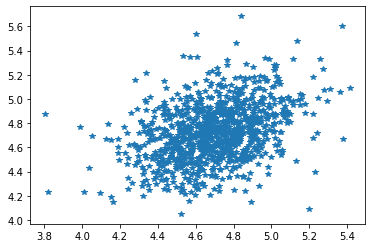

In [188]:
plt.plot(outy[-1,:,0], outy[-1,:,1], '*')
plt.show()